In [1]:
import numpy as np
import time, os
import multiprocess as mp
import matplotlib.pyplot as plt

from sound import SoundController

In [7]:
%%writefile sound.py
import numpy as np
import time

class SoundController:
    # https://python-sounddevice.readthedocs.io/en/0.3.15/api/streams.html#sounddevice.OutputStream
    
    default_cfg = {
        "device": [1, 26],
        "n_channels": 4,
        "sounds": [
            {"freq": 460, "amp": 0.13, "channels": [1, 3]},
            {"freq": 660, "amp": 0.05, "channels": [1, 3]}, 
            {"freq": 860, "amp": 0.15, "channels": [1, 3]}, 
            {"freq": 1060, "amp": 0.25, "channels": [1, 3]},
            {"freq": 1320, "amp": 0.2, "channels": [1, 3]}, 
            {"freq": 20000, "amp": 0.55, "channels": [1, 3]}
        ],
        "pulse_duration": 0.05,
        "sample_rate": 44100,
        "latency": 0.25,
        "volume": 0.7,
        "roving": 5.0,
        "file_path": "sounds.csv"
    }
    
    @classmethod
    def get_pure_tone(cls, freq, duration, sample_rate=44100):
        x = np.linspace(0, duration * freq * 2*np.pi, int(duration*sample_rate), dtype=np.float32)
        return np.sin(x)

    @classmethod
    def get_cos_window(cls, tone, win_duration, sample_rate=44100):
        x = np.linspace(0, np.pi/2, int(win_duration * sample_rate), dtype=np.float32)
        onset =  np.sin(x)
        middle = np.ones(len(tone) - 2 * len(x))
        offset = np.cos(x)
        return np.concatenate([onset, middle, offset])

    @classmethod
    def get_tone_stack(cls, cfg):
        silence = np.zeros(2, dtype='float32')
        sounds = {0: np.column_stack([silence for x in range(cfg['n_channels'])])}

        for i, snd in enumerate(cfg['sounds']):
            tone = cls.get_pure_tone(snd['freq'], cfg['pulse_duration'], cfg['sample_rate']) * cfg['volume']
            tone = tone * cls.get_cos_window(tone, 0.01, cfg['sample_rate'])  # onset / offset
            tone = tone * snd['amp']
            
            sound = np.zeros([len(tone), cfg['n_channels']], dtype='float32')
            for j in snd['channels']:
                sound[:, j-1] = tone
           
            sounds[i + 1] = sound
            #sounds[i + 1] = np.column_stack((nothing, tone, tone, tone))

        return sounds
        
    @classmethod
    def run(cls, selector, status, cfg):
        """
        selector        mp.Value object to set the sound to be played
        status          mp.Value object to stop the loop
        """
        import sounddevice as sd  # must be inside the function
        import numpy as np
        import time
        
        sounds = cls.get_tone_stack(cfg)

        sd.default.device = cfg['device']
        sd.default.samplerate = cfg['sample_rate']
        stream = sd.OutputStream(samplerate=cfg['sample_rate'], channels=4, dtype='float32', blocksize=256)
        stream.start()

        next_beat = time.time() + cfg['latency']
        with open(cfg['file_path'], 'w') as f:
            f.write("time,id\n")

        while status.value > 0:
            if status.value == 2:  # running state
                t0 = time.time()
                if t0 < next_beat:
                    #time.sleep(0.0001)  # not to spin the wheels too much
                    if stream.write_available > 2:
                        stream.write(sounds[0])  # silence
                    continue

                roving = 10**((np.random.rand() * cfg['roving'] - cfg['roving']/2.0)/20.)
                stream.write(sounds[int(selector.value)] * roving)
                with open(cfg['file_path'], 'a') as f:
                    f.write(",".join([str(x) for x in (t0, selector.value)]) + "\n")

                next_beat += cfg['latency']
                
                if stream.write_available > 2:
                    stream.write(sounds[0])  # silence
            
            else:  # idle state
                next_beat = time.time() + cfg['latency']
                time.sleep(0.05)
                
        stream.stop()
        print('Sound stopped')

Overwriting sound.py


### building sound stack

In [1]:
import numpy as np
import time, os
from sound import SoundController

cfg = SoundController.default_cfg
sounds = SoundController.get_tone_stack(cfg)

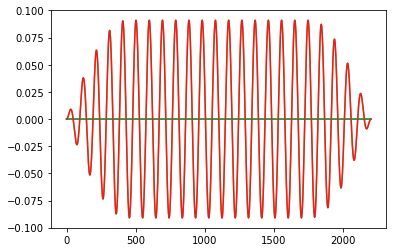

In [5]:
import matplotlib.pyplot as plt

plt.plot(sounds[1])

### roving and onset window

In [4]:
from sound import SoundController

duration = 0.05
freq = 440

tone = SoundController.get_pure_tone(freq, duration)
tone = tone * SoundController.get_cos_window(tone, 0.01)

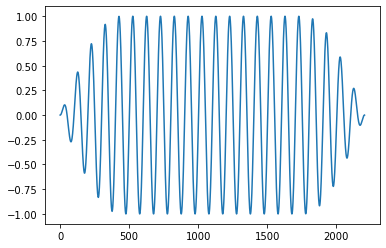

In [5]:
import matplotlib.pyplot as plt
plt.plot(tone)

### Testing sound pulses with MP

In [1]:
import numpy as np
import time, os
import multiprocess as mp
from sound import SoundController

# sound selector: 0 - silence, 1 - tone 1, 2 - tone 2
selector = mp.Value('i', 1)

# loggin status: 1 - idle, 2 - running, 0 - stopped
status = mp.Value('i', 1)

cfg = SoundController.default_cfg
cfg['device'] = [1, 26]  # 'M-Audio Delta ASIO'
sc = mp.Process(target=SoundController.run, args=(selector, status, cfg))
sc.start()

# nothing happens for a second
time.sleep(1)

status.value = 2
for i in range(5):
    time.sleep(2)
    selector.value = 3 if selector.value == 1 else 1

# stop
status.value = 0
time.sleep(0.2)
sc.join()

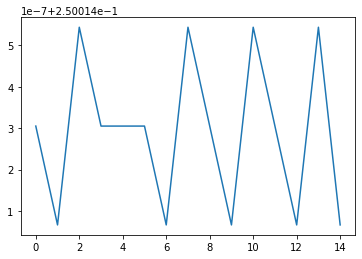

In [3]:
import matplotlib.pyplot as plt

ds = np.loadtxt('test_sound_log.csv', delimiter=',', skiprows=1)
plt.plot(np.diff(ds[:, 0]))

### Sounddevice playground

In [7]:
import sounddevice as sd
[x for x in sd.query_devices() if x['name'].find('ASIO') > 0]

[{'name': 'M-Audio Delta ASIO',
  'hostapi': 2,
  'max_input_channels': 6,
  'max_output_channels': 10,
  'default_low_input_latency': 0.005804988662131519,
  'default_low_output_latency': 0.005804988662131519,
  'default_high_input_latency': 0.09287981859410431,
  'default_high_output_latency': 0.09287981859410431,
  'default_samplerate': 44100.0}]

In [8]:
import sounddevice as sd
import numpy as np

sd.default.device = [1, 26]
sd.default.samplerate = 44100
stream = sd.OutputStream(samplerate=44100, channels=4, dtype='float32')
stream.start()

In [9]:
# 3rd channel - left arena speaker
# 1st channel - right arena speaker

In [10]:
duration = 2
x1 = np.linspace(0, duration * 110 * 2*np.pi, int(duration*44100), dtype=np.float32)
x2 = np.linspace(0, duration * 220 * 2*np.pi, int(duration*44100), dtype=np.float32)
y1 = np.sin(x1)
y2 = np.sin(x2)
sil = np.zeros(len(x1), dtype=np.float32)

for i in range(50):
    if i % 2 == 0:
        output = np.column_stack([y1, sil, sil, sil])
    else:
        output = np.column_stack([sil, sil, y2, sil])
    stream.write(output*0.5)

In [4]:
stream.stop()